**Twint is an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter profiles without using Twitter's API. also I use aiohttp and asyncio for Asynchronous Web Scraping. in case of asynchronous web scraping, your scraper runs in parallel processes to collect data from websites and does not wait for one code to finish its execution**

In [ ]:
!git clone https://github.com/twintproject/twint.git
!cd twint
!pwd
import os
os.chdir('twint')
!pwd
!pip install . -r requirements.txt

!pip install nest_asyncio
!pip install aiohttp==3.7.0

!pip install yfinance

In [47]:
import yfinance
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.max_columns = 100
plt.style.use('fivethirtyeight')

import twint

The only reason why we use nest_asyncio is because this tutorial is written in a jupyter notebook, however if you wanted to write the same web scraper code in a python file, then you would’nt need to install or run the following code block:

In [2]:
import nest_asyncio
nest_asyncio.apply()

**twint has a bug. I solved it by uncomment line 92 in the url.py file in twint folder**

### **Data extraction Twitter**

In [5]:
from google.colab import drive  # I save tweets in my drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/")

In [3]:
from urllib3.exceptions import ProtocolError
from urllib3.exceptions import IncompleteRead

In [6]:
def get_tweets():
    c = twint.Config()

    c.Search = "bitcoin"
    c.Count = True
    c.Pandas = True

    c.Since = '2022-03-10 10:00:00'
    #c.Until = '2022-05-06 10:00:00'

    c.Popular_tweets = True
    c.Hide_output = True
    c.Store_json = True
    c.Min_likes = 200
    #c.Limit = 3000
    c.Output = 'bitcoin-2022.json'
    c.Resume = "bitcoin-2022.raw"

    twint.run.Search(c)

    while True:
        try:
            twint.run.Search(c)

        except ProtocolError as error:
              print (str(error))
              continue

        except IncompleteRead as IR:
                print (str(IR))
                continue


In [ ]:
get_tweets()

##Data cleaning Twitter

In [8]:
import pandas as pd

In [5]:
data = pd.read_json('/content/drive/MyDrive/bitcoin-2022.json', lines=True)
data.to_csv('bitcoin-2022.csv', encoding='utf-8', index=False)

In [20]:
df = pd.read_csv('/content/bitcoin-2022.csv', low_memory = False, skiprows=0, lineterminator='\n')
df = df[['id','username', 'name','urls','created_at','replies_count','likes_count','retweets_count']]
df = df.rename(columns={'id':'id','username':'user', 'name':'fullname','urls':'url','created_at':'timestamp','replies_count':'replies','likes_count':'likes','retweets_count':'retweets'})

In [21]:
def dt_func(z):
    t = pd.Timestamp(z)
    return pd.Timestamp.date(t)
df.timestamp = df.timestamp.apply(dt_func)

In [22]:
df.head(3)

,id,user,fullname,url,timestamp,replies,likes,retweets
0,1465983803399163904,kanemitsumidori,金光碧🐈🍋⚡️ / Kanemitsu Midori / bitFlyer,[],2021-12-01,12,281,29
1,1465982973749071876,coinerstakingls,Crypto Bros Taking Ls,[],2021-12-01,41,4565,67
2,1465981624458297351,thomascabaret84,Thomas Cabaret,[],2021-12-01,44,90,1


In [23]:
df = df.sort_values(by=['timestamp'], ascending=True)

In [24]:
df = df.drop_duplicates()

In [25]:
df.head(3)

,id,user,fullname,url,timestamp,replies,likes,retweets
339254,1253736753061662720,scott_lew_is,𝚂𝚌𝚘𝚝𝚝 𝙻Ξ𝚠𝚒𝚜 🌾,['https://cointelegraph.com/news/bitfinex-list...,2020-04-24,4,58,12
339220,1253780765378260992,bitcoinissaving,Bitcoin is Saving,[],2020-04-24,10,65,2
339219,1253781526531145729,my_livin_truth,OPTIMIST FIELDS,[],2020-04-24,8,65,4


In [26]:
df_d = pd.DataFrame(columns=['Date', 'tweets_number', 'replies', 'likes', 'retweets'])

In [27]:
df_d = pd.DataFrame(df['timestamp'].value_counts())
df_d = df_d.reset_index()
df_d.columns = ['Date','tweets_number']
df_d = df_d.sort_values(by=['Date'], ascending=True)
df_d.insert(0, 'id_d', range(1, 1 + len(df_d)))
df_d.head(3)

,id_d,Date,tweets_number
586,1,2020-04-24,61
553,2,2020-04-25,148
547,3,2020-04-26,150


In [28]:
df_date = pd.DataFrame(df_d['Date'])
df_date = df_date.sort_values(by=['Date'], ascending=True)
df_date.insert(0, 'id_date', range(1, 1 + len(df_date)))
df_date.head(3)

,id_date,Date
586,1,2020-04-24
553,2,2020-04-25
547,3,2020-04-26


In [29]:
for date in df_d['Date']:
    df_d.loc[df_d['Date'] == date, 'likes'] = df.loc[df['timestamp'] == date, 'likes'].sum()
    df_d.loc[df_d['Date'] == date, 'replies'] = df.loc[df['timestamp'] == date, 'replies'].sum()
    df_d.loc[df_d['Date'] == date, 'retweets'] = df.loc[df['timestamp'] == date, 'retweets'].sum()

In [30]:
df_d.Date = pd.to_datetime(df_d.Date)

In [31]:
df_d.tail()

,id_d,Date,tweets_number,likes,replies,retweets
220,583,2021-11-27,643,504885.0,51112.0,108037.0
145,584,2021-11-28,761,567120.0,68436.0,87678.0
60,585,2021-11-29,1031,734569.0,59198.0,116512.0
104,586,2021-11-30,843,593190.0,64732.0,108515.0
458,587,2021-12-01,225,121716.0,11811.0,24424.0


##data scaling

**I use the Bollinger band indicator and below function to scale the data**

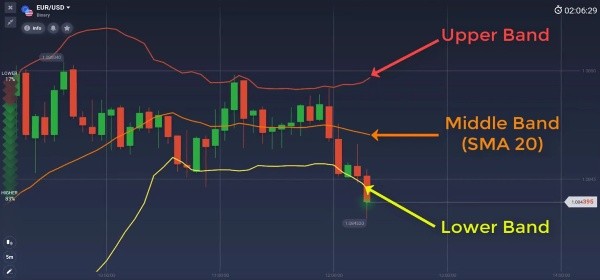

In [34]:
def scaling_func(series):
  df_res = pd.DataFrame()
  period=20
  df_res['SMA_20'] = series.rolling(window=period).mean()
  df_res['STD_20'] = series.rolling(window=period).std()
  df_res['Upper_Band'] = df_res['SMA_20'] + (df_res['STD_20'] *2)
  df_res['Lower_Band'] = df_res['SMA_20'] - (df_res['STD_20'] *2)
  df_res['series_scaled'] = (series - df_res['SMA_20'])/(df_res['Upper_Band']-df_res['Lower_Band'])
  return df_res['series_scaled'].values

In [37]:
df_d.head(3)

,id_d,Date,tweets_number,likes,replies,retweets
586,1,2020-04-24,61,11919.0,1178.0,1955.0
553,2,2020-04-25,148,48840.0,5779.0,9971.0
547,3,2020-04-26,150,41184.0,6282.0,7040.0


In [38]:
df_s = df_d[['Date', 'tweets_number',	'likes', 'replies', 'retweets']].copy()

In [43]:
df_price = yfinance.download(['BTC-USD'], start='2014-01-01', interval='1d')[['Close']]
df_price = df_price.reset_index()
df_price.columns = ['Date', 'Close']
df_price['Date'] = pd.to_datetime(df_price.Date).dt.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


In [44]:
df_btc = pd.merge(df_price, df_s, left_on='Date', right_on='Date')

In [45]:
df_btc.head(3)

,Date,Close,tweets_number,likes,replies,retweets
0,2020-04-24,7550.900879,61,11919.0,1178.0,1955.0
1,2020-04-25,7569.936035,148,48840.0,5779.0,9971.0
2,2020-04-26,7679.867188,150,41184.0,6282.0,7040.0


**ob_func is a momentum function that uses target flow to predict changes in stock price. This function works like as OBV indicator**

In [50]:
def ob_func(price_series, target_series):
  return np.where(price_series > price_series.shift(1), target_series, np.where(price_series < price_series.shift(1), -target_series, 0)).cumsum()

In [51]:
df_btc['ob_tweetsNumber'] = ob_func(df_btc.Close, df_btc.tweets_number)
df_btc['ob_likes'] = ob_func(df_btc.Close, df_btc.likes)
df_btc['ob_replies'] = ob_func(df_btc.Close, df_btc.replies)
df_btc['ob_retweets'] = ob_func(df_btc.Close, df_btc.retweets)

In [58]:
df_btc['sc_Close'] = scaling_func(df_btc.Close)
df_btc['sc_tweetsNumber'] = scaling_func(df_btc.ob_tweetsNumber)
df_btc['sc_likes'] = scaling_func(df_btc.ob_likes)
df_btc['sc_replies'] = scaling_func(df_btc.ob_replies)
df_btc['sc_retweets'] = scaling_func(df_btc.ob_retweets)

In [59]:
columns = ['sc_Close', 'sc_tweetsNumber', 'sc_likes', 'sc_replies', 'sc_retweets']

**wow! I extracted new features from Twitter. And they have a very good relationship with the price**

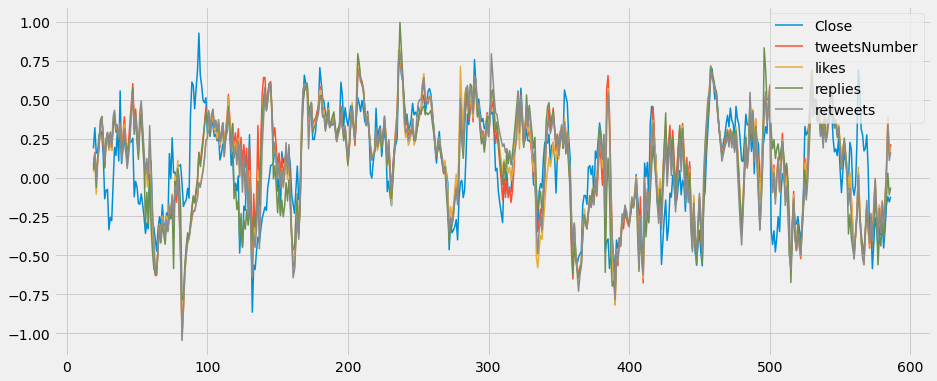

In [192]:
plt.figure(figsize=(14,6))
for column in columns:
  plt.plot(df_btc[column], label=column[3:], lw=1.5)
plt.legend(loc='upper right')
plt.show()

In [215]:
corr = df_btc[columns].set_axis(['Bitcoin Price', 'Tweets Number', 'Likes', 'Replies', 'Retweets'], axis=1, inplace=False).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,Bitcoin Price,Tweets Number,Likes,Replies,Retweets
Bitcoin Price,1.00,0.69,0.70,0.73,0.69
Tweets Number,0.69,1.00,0.98,0.93,0.96
Likes,0.70,0.98,1.00,0.94,0.98
Replies,0.73,0.93,0.94,1.00,0.94
Retweets,0.69,0.96,0.98,0.94,1.00


***Now I use a model to predict the price***

##Model

In [135]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler

In [73]:
df_log = df_btc[columns].dropna()

In [74]:
df_log.head(3)

,sc_Close,sc_tweetsNumber,sc_likes,sc_replies,sc_retweets
19,0.186916,0.072825,0.036872,0.051361,0.092304
20,0.320175,0.161452,0.110917,0.135259,0.153975
21,0.156945,-0.003921,-0.106674,-0.064102,-0.026700


In [173]:
timestamp = 20 #a series of data points indexed (or listed) in time order and use to predict the next value or values in the sequence
length_of_target_sequence = 1

X = []
Y = []

for k in range(len(df_log)-timestamp):
  X.append(df_log.iloc[k : k + timestamp, :])
  Y.append(df_log.iloc[k + timestamp: k + timestamp + length_of_target_sequence, 0])

X = np.array(X)
Y = np.array(Y)

X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [174]:
X.shape, Y.shape

((548, 20, 5), (548, 1))

In [176]:
X_train, X_val = X[:-100], X[-100:]
y_train, y_val = Y[:-100], Y[-100:]

In [177]:
class Modelnn(keras.Model):
  def __init__(self, inputShape, num_hidden_layer, num_unit_lstm, **kwargs):
    super().__init__(**kwargs)

    self.InputShape = inputShape
    self.n_hidden_layer = num_hidden_layer

    self.BN_layer_input = layers.BatchNormalization(input_shape=self.InputShape)
    self.conv_layer = layers.Conv1D(32, 2, padding='same', activation='relu')
    self.flatten_layer = layers.Flatten()

    self.layers_list = []
    for i in range(self.n_hidden_layer):
      self.layers_list.append(layers.LSTM(num_unit_lstm, return_sequences=True))
      self.layers_list.append(layers.Dropout(0.3))
      self.layers_list.append(layers.BatchNormalization())

    self.last_lstm = layers.LSTM(128)
    self.Dense = layers.Dense(32, activation='relu')
    self.Dropout_layer = layers.Dropout(0.3)
    self.last_Dense = layers.Dense(1)
  
  def call(self, inputs):
    x = self.BN_layer_input(inputs)
    out_conv = self.conv_layer(x)
    out_conv = self.flatten_layer(out_conv)

    for layer in self.layers_list:
      x = layer(x)
    
    x = self.last_lstm(x)
    x = self.Dense(x)

    concat_layer = layers.concatenate([x, out_conv])
    output_ = self.last_Dense(x)
    return output_

In [183]:
modelnn = Modelnn(X_train.shape[1:], 1, 128)

In [185]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.TensorBoard('/content/logsF'),
]

opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
modelnn.compile(loss='mse', metrics='mae', optimizer=opt)

In [186]:
history = modelnn.fit(X_train, y_train, batch_size=32, epochs=100,
                      shuffle=True, validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/100


14/14 [==============================] - 6s 166ms/step - loss: 0.1723 - mae: 0.2862 - val_loss: 0.0964 - val_mae: 0.2686
Epoch 2/100
14/14 [==============================] - 1s 80ms/step - loss: 0.0483 - mae: 0.1722 - val_loss: 0.0986 - val_mae: 0.2730
Epoch 3/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0511 - mae: 0.1772 - val_loss: 0.0901 - val_mae: 0.2561
Epoch 4/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0425 - mae: 0.1623 - val_loss: 0.0904 - val_mae: 0.2571
Epoch 5/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0398 - mae: 0.1545 - val_loss: 0.0937 - val_mae: 0.2594
Epoch 6/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0400 - mae: 0.1539 - val_loss: 0.0893 - val_mae: 0.2546
Epoch 7/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0312 - mae: 0.1382 - val_loss: 0.0908 - val_mae: 0.2503
Epoch 8/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0328 - mae:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/logsF

In [187]:
y_train_pred = modelnn.predict(X_train)
y_val_pred = modelnn.predict(X_val)

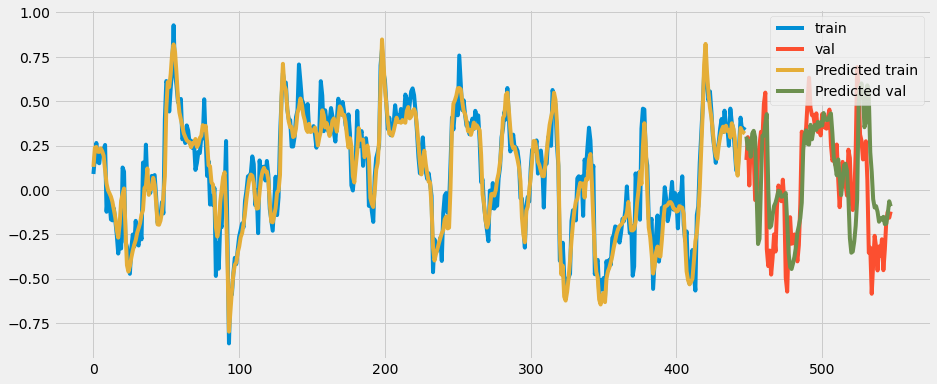

In [188]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(len(X)-100), y_train, label="train")
plt.plot(np.arange(len(X)-100, len(X)), y_val, label="val")
plt.plot(np.arange(len(X)-100), y_train_pred, label="Predicted train")
plt.plot(np.arange(len(X)-100, len(X)), y_val_pred, label="Predicted val")
plt.legend(loc='upper right')
plt.show()